# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [34]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator


SEED = 42
np.random.seed(SEED)


stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer()
snowball_stemmer = SnowballStemmer('english')

In [4]:
# import spacy
# spacy_en = spacy.load('en')

# def tokenizer(text): # create a tokenizer function
#     return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [35]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

def tokenizer(text):
    tokens = tweet_tokenizer.tokenize(snowball_stemmer.stem(text))
    result = [word for word in tokens if word != ' '  \
              and word.strip() not in punctuation + '«»—…“”№–']
    
    return result

In [36]:
df = pd.read_csv('imdb_master.csv', encoding='latin-1', index_col=0)
df.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [37]:
train = df[df['type'] == 'train']
test = df[df['type'] =='test']
print(train.shape)
print(test.shape)

(75000, 4)
(25000, 4)


In [9]:
train.head()

,type,review,label,file
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt


In [10]:
df['label'].value_counts()

unsup    50000
pos      25000
neg      25000
Name: label, dtype: int64

In [38]:
train[['review','label']].to_csv('train.csv', index=False)
test[['review','label']].to_csv('test.csv', index=False)

In [41]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stop_words)
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

train = TabularDataset('train.csv', format='csv', 
                         fields=[('review', TEXT), ('label', LABEL)], 
                         skip_header=True)

test = TabularDataset('test.csv', format='csv', 
                         fields=[('review', TEXT), ('label', LABEL)], 
                         skip_header=True)

In [42]:
TEXT.build_vocab(train, min_freq=10, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

36839

In [43]:
weights_matrix = TEXT.vocab.vectors

In [44]:
TEXT.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<eos>',
 'br',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'even']

In [66]:
LABEL.build_vocab(train)

In [45]:
train, valid = train.split(0.7, stratified=True)

In [62]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, weights_matrix, hidden_size, kernels, freeze_value):
        super(MyModel, self).__init__()
        
        if weights_matrix is None:
            print('random initialization.')
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        else:
            self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=freeze_value)
            
            if freeze_value:
                print('pretrained word embeddings with frozen weights.')
            else:
                print('initializing from pretrained weights.')
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [58]:
def train_nn(model, epochs, train_iterator, valid_iterator, optimizer, scheduler, criterion):
    min_loss = np.inf
    no_impr = 0
    
    lr = []
    all_train_loss = []
    all_val_loss = []
    
    for epoch in range(epochs):
        val_loss_history = []
        train_loss_history = []
        
        for batch in train_iterator:
            optimizer.zero_grad()
            
            pred = model.forward(batch.review[0])
            loss = criterion(pred, batch.label)
            tr_loss = loss.item()
            train_loss_history.append(tr_loss)
        
            loss.backward()
            optimizer.step()
                
        train_mean = np.mean(train_loss_history)
        all_train_loss.append(train_mean)
        
        with tt.no_grad():
            for val_batch in valid_iterator:
                val_pred = model.forward(val_batch.review[0])
                val_loss_crit = criterion(val_pred, val_batch.label)
                valid_loss = val_loss_crit.item()
                val_loss_history.append(valid_loss)
        
            val_loss = np.mean(val_loss_history)
            all_val_loss.append(val_loss)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr = 0

        elif no_impr < scheduler.patience:
            no_impr += 1

        else:
            print('Early stopping (%dth epoch)' % (epoch + 1))
            break
        
        lr.append(optimizer.param_groups[0]['lr'])
        scheduler.step(val_loss)
    
        print('Epoch %d, Train Loss: %.4f, Validation Loss: %.4f' % (epoch + 1, train_mean, val_loss))
        
    return lr, all_train_loss, all_val_loss

In [48]:
def eval_test(model, test_iterator, criterion):
    epoch_loss = 0

    with tt.no_grad():
        for batch in test_iterator:
            pred = model.forward(batch.review[0])
            loss = criterion(pred, batch.label)
            epoch_loss += loss.data.item()

    return epoch_loss / len(test_iterator)

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def pl_lr(lr):
    plt.plot(range(len(lr)), lr)
    plt.xlabel('Num of epochs')
    plt.ylabel('Learning rate')
    plt.title('Learning rate vs number of epochs')

In [51]:
def pl_loss(train_loss, val_loss):
    plt.plot(range(len(val_loss)), val_loss, label='validation loss')
    plt.plot(range(len(train_loss)), train_loss, label='train loss') 
    plt.xlabel('Num of epochs')
    plt.ylabel('Loss value')
    plt.legend()
    plt.title('Train and Validation losses')

In [83]:
def pl_val_curve(test_1, test_2, test_3):
    ax = plt.figure(figsize=(14,8)).add_subplot(111)

    x = 'pretrained word embeddings with frozen weights', 'without pretrained weights', 'random initialization'
    y = test_1, test_2, test_3

    plt.plot(x, y)

    for i, j in zip(x, y):  
        ax.annotate('%s' % j, xy=(i, j), textcoords='offset points')

    plt.xlabel('Model type')
    plt.ylabel('Test loss value')
    plt.title('Validation curve')

# From pretrained with frozen weights

In [64]:
tt.cuda.empty_cache()

batch_size = 256
epochs = 15

criterion = nn.CrossEntropyLoss()

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

pretrained_frozen = MyModel(len(TEXT.vocab.itos),
                                  embed_size=100,
                                  weights_matrix=weights_matrix,
                                  hidden_size=128,
                                  kernels=[2,3,4,5],
                                  freeze_value=True
                                 )

optimizer_pretrained_frozen = optim.Adam(pretrained_frozen.parameters())
scheduler_pretrained_frozen = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pretrained_frozen, 
    patience=5, 
    verbose=True, 
    cooldown=5
)

pretrained word embeddings with frozen weights.


In [67]:
%%time

lr_1, tr_loss_1, val_loss_1 = train_nn(
    pretrained_frozen, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_pretrained_frozen, 
    scheduler_pretrained_frozen, 
    criterion
)

Epoch 1, Train Loss: 0.8478, Validation Loss: 1.0017
Epoch 2, Train Loss: 0.8151, Validation Loss: 1.2399
Epoch 3, Train Loss: 0.8120, Validation Loss: 2.0863
Epoch 4, Train Loss: 0.8122, Validation Loss: 1.1353
Epoch 5, Train Loss: 0.8087, Validation Loss: 1.1153
Epoch 6, Train Loss: 0.8100, Validation Loss: 1.1113
Early stopping (7th epoch)
Wall time: 1h 9min 22s


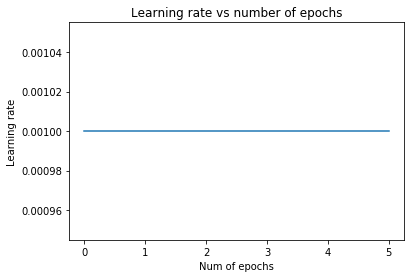

In [68]:
pl_lr(lr_1)

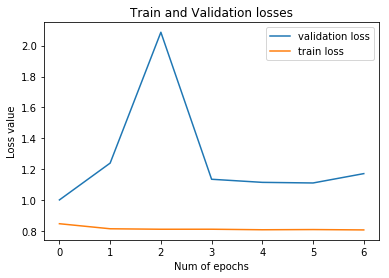

In [69]:
pl_loss(tr_loss_1, val_loss_1)

In [71]:
test_1 = eval_test(pretrained_frozen, test_iterator, criterion)

# without frozen weights

In [72]:
tt.cuda.empty_cache()

batch_size = 256
epochs = 15

criterion = nn.CrossEntropyLoss()

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

pretrained_ = MyModel(len(TEXT.vocab.itos),
                                  embed_size=100,
                                  weights_matrix=weights_matrix,
                                  hidden_size=128,
                                  kernels=[2,3,4,5],
                                  freeze_value=False
                                 )

optimizer_pretrained_ = optim.Adam(pretrained_.parameters())
scheduler_pretrained_ = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pretrained_, 
    patience=5, 
    verbose=True, 
    cooldown=5
)

initializing from pretrained weights.


In [73]:
%%time

lr_2, tr_loss_2, val_loss_2 = train_nn(
    pretrained_, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_pretrained_frozen, 
    scheduler_pretrained_frozen, 
    criterion
)

Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch 1, Train Loss: 1.1141, Validation Loss: 1.0817
Epoch 2, Train Loss: 1.1141, Validation Loss: 1.0817
Epoch 3, Train Loss: 1.1141, Validation Loss: 1.0817
Epoch 4, Train Loss: 1.1140, Validation Loss: 1.0817
Epoch 5, Train Loss: 1.1141, Validation Loss: 1.0817
Epoch 6, Train Loss: 1.1142, Validation Loss: 1.0817
Early stopping (7th epoch)
Wall time: 1h 56min 13s


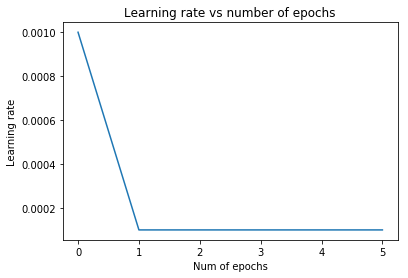

In [74]:
pl_lr(lr_2)

Не могу понять, почему графики получились такими

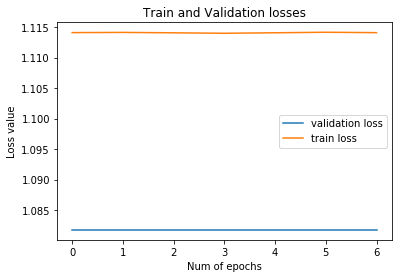

In [75]:
pl_loss(tr_loss_2, val_loss_2)

In [76]:
test_2 = eval_test(pretrained_, test_iterator, criterion)

In [77]:
tt.cuda.empty_cache()

batch_size = 256
epochs = 15

criterion = nn.CrossEntropyLoss()

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

own_init = MyModel(len(TEXT.vocab.itos),
                                  embed_size=100,
                                  weights_matrix=None,
                                  hidden_size=128,
                                  kernels=[2,3,4,5],
                                  freeze_value=False
                                 )

optimizer_own_init = optim.Adam(own_init.parameters())
scheduler_own_init = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_own_init, 
    patience=5, 
    verbose=True, 
    cooldown=5
)

random initialization.


In [78]:
%%time

lr_3, tr_loss_3, val_loss_3 = train_nn(
    own_init, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_own_init, 
    scheduler_own_init, 
    criterion
)

Epoch 1, Train Loss: 0.8910, Validation Loss: 0.8685
Epoch 2, Train Loss: 0.8558, Validation Loss: 0.9538
Epoch 3, Train Loss: 0.8145, Validation Loss: 1.1976
Epoch 4, Train Loss: 0.7664, Validation Loss: 1.2057
Epoch 5, Train Loss: 0.7360, Validation Loss: 1.5209
Epoch 6, Train Loss: 0.7131, Validation Loss: 1.6191
Early stopping (7th epoch)
Wall time: 1h 53min 34s


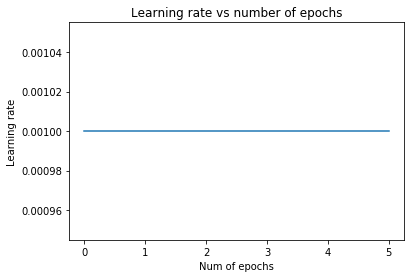

In [79]:
pl_lr(lr_3)

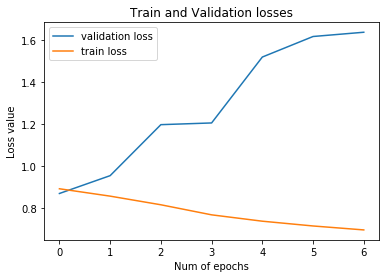

In [80]:
pl_loss(tr_loss_3, val_loss_3)

In [81]:
test_3 = eval_test(own_init, test_iterator, criterion)

D:\Anaconda3\lib\site-packages\matplotlib\text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


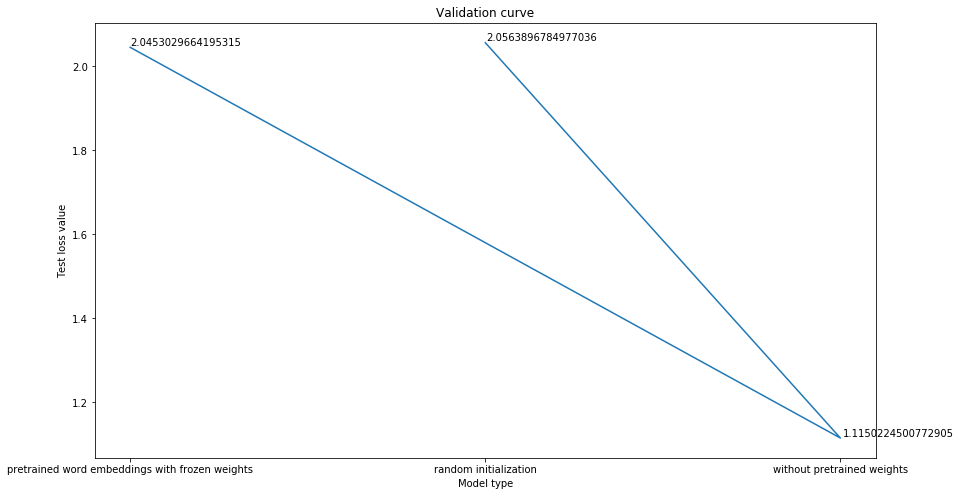

In [84]:
pl_val_curve(test_1, test_2, test_3)